In [1]:
# Imports de utilidades de Python
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
import git
import os, sys

path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
os.chdir(os.path.join(path_git, 'utils'))
from functions_cosmo import *
from functions import *

os.chdir(path_git)

2024-12-05 00:59:08.500948: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Los datos
Vamos a trabajar con datos de modulo de distancia de Supernovas tipo Ia, adquiridos a partir de la colaboración Pantheon Plus. Son datos de 1048 supernovas, con redshifts entre 0.01 y 2.26. Los datos se encuentran en el archivo 'Pantheon+SH0ES.dat'.



In [2]:
os.chdir(os.path.join(path_git, 'source','PPS'))
ds_SN_plus = read_data_pantheon_plus('Pantheon+SH0ES.dat',
                        'covmat_pantheon_plus_only.npz')
os.chdir(path_git)

A partir de los datos de la magnitud aparente $m_b$, nos construimos los datos

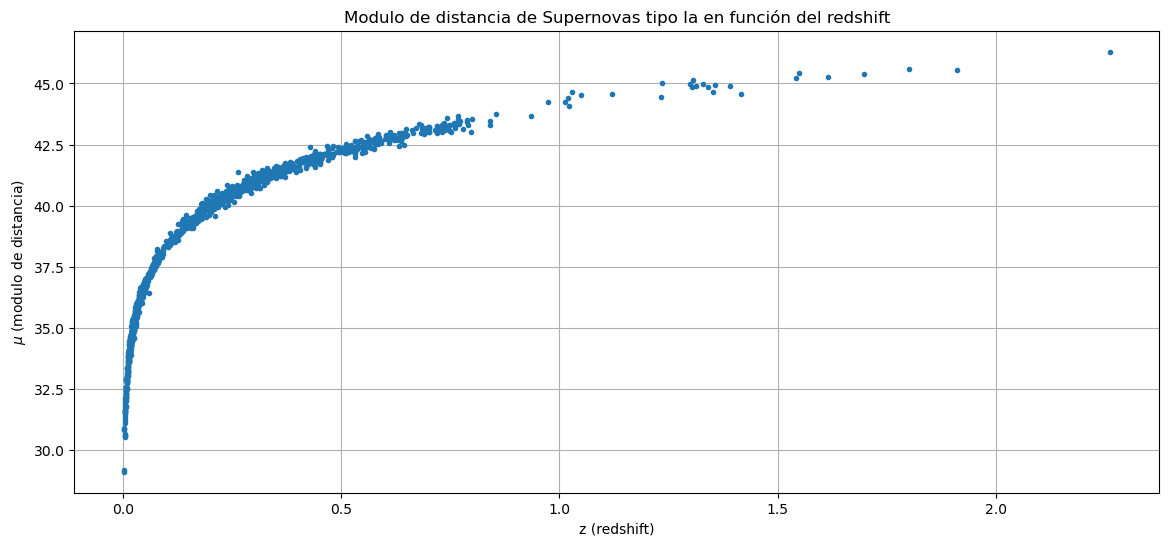

In [3]:
M_abs = -19.37 #Magnitud absoluta de las supernovas
zhd, _, _, mb = ds_SN_plus
muobs =  np.array(mb - M_abs)
zhd = np.array(zhd)

# Graficar la señal temporal
plt.figure(figsize=(14, 6))
plt.plot(zhd,muobs,'.')
plt.xlabel('z (redshift)')
plt.ylabel(r'$\mu$ (modulo de distancia)')
plt.title('Modulo de distancia de Supernovas tipo Ia en función del redshift')
plt.grid(True)
plt.show()

# Los datos
Vamos a trabajar con datos de modulo de distancia de Supernovas tipo Ia, adquiridos a partir de la colaboración Pantheon Plus. Son datos de 1048 supernovas, con redshifts entre 0.01 y 2.26. Los datos se encuentran en el archivo 'Pantheon+SH0ES.dat'.



In [4]:
os.chdir(os.path.join(path_git, 'source','PPS'))
ds_SN_plus = read_data_pantheon_plus('Pantheon+SH0ES.dat',
                        'covmat_pantheon_plus_only.npz')
os.chdir(path_git)

A partir de los datos de la magnitud aparente $m_b$, nos construimos los datos

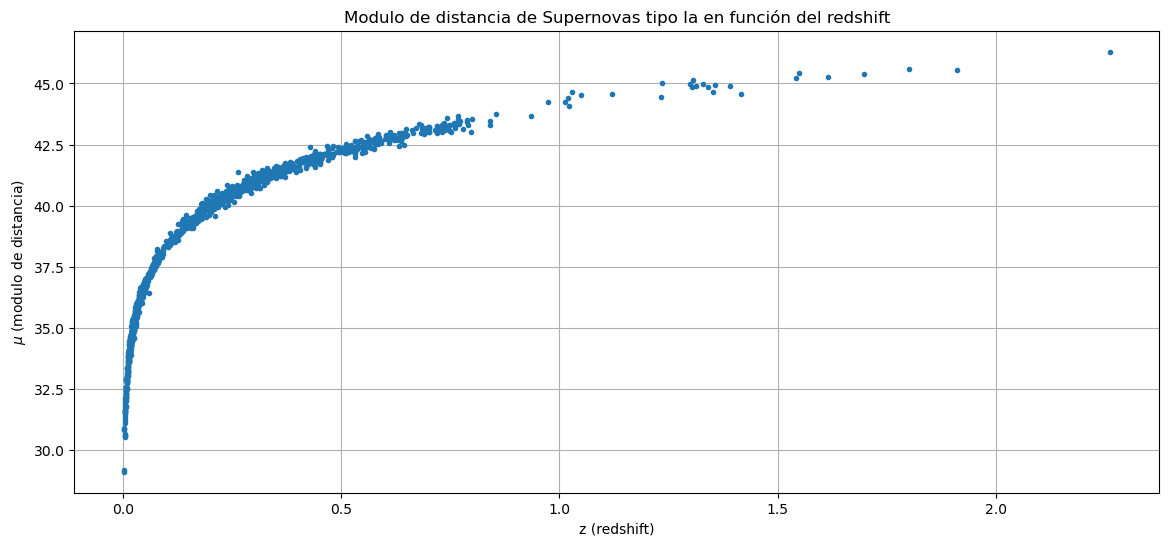

In [5]:
M_abs = -19.37 #Magnitud absoluta de las supernovas
zhd, _, _, mb = ds_SN_plus
muobs =  np.array(mb - M_abs)
zhd = np.array(zhd)

# Graficar la señal temporal
plt.figure(figsize=(14, 6))
plt.plot(zhd,muobs,'.')
plt.xlabel('z (redshift)')
plt.ylabel(r'$\mu$ (modulo de distancia)')
plt.title('Modulo de distancia de Supernovas tipo Ia en función del redshift')
plt.grid(True)
plt.show()

# El análisis preliminar
A modo de introducción, veamos un ejemplo de cómo podemos utilizar la metodología propuesta para analizar esta base de datos. Vamos a trabajar con los datos suavizados:

True


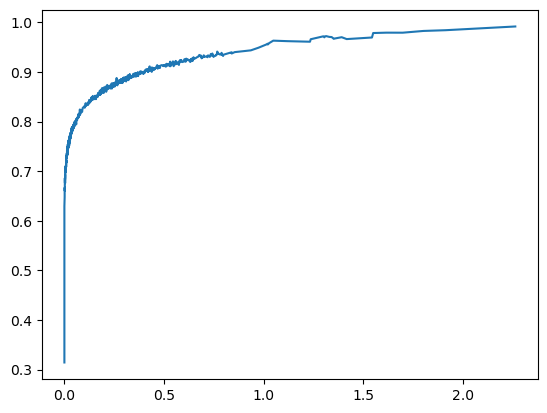

In [6]:
t = np.array(zhd)
raw_seq = np.array(muobs)/np.max(muobs)

len(raw_seq)
print(np.all(t == np.sort(t)))

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

raw_seq = smooth(raw_seq, 2)
plt.plot(t,raw_seq)

In [7]:
# Parámetros de la simulación

# choose a number of time steps
look_back = 50

# Cantidad de valores por cada paso temporal
n_features = 1

# Cantidad de pasos que queremos predecir hacia adelante
window_size = 400

# longitud de la cadena izquierda
len_left_chain = 600

# longitud de la cadena derecha
len_right_chain = len(raw_seq) - len_left_chain - window_size

In [8]:
print(len_left_chain, len_right_chain)

600 657


In [9]:
raw_seq_1 = raw_seq[0:len_left_chain]
t_1 = t[0:len_left_chain]

print(len(raw_seq_1),len_left_chain)

600 600


In [10]:
raw_seq_2 = raw_seq[len_left_chain+window_size:len_left_chain+window_size + len_right_chain]
t_2 = t[len_left_chain+window_size:len_left_chain+window_size + len_right_chain]

raw_seq_2_bw = raw_seq_2[::-1]
t_2_bw = t_2[::-1]

print(len(raw_seq_2),len_right_chain)

657 657


In [11]:
t_window = t[len_left_chain:len_left_chain+window_size]
raw_seq_window = raw_seq[len_left_chain:len_left_chain+window_size]
print(len(raw_seq_window),window_size)

400 400


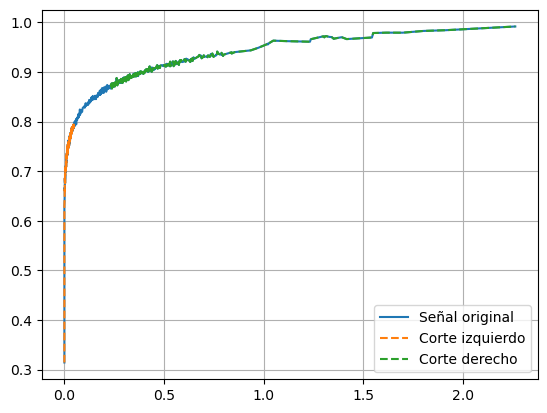

In [12]:
plt.plot(t,raw_seq, label='Señal original')
plt.plot(t_1,raw_seq_1, '--', label='Corte izquierdo')
plt.plot(t_2,raw_seq_2, '--', label='Corte derecho')
plt.grid()
plt.legend()
plt.show()

In [13]:
print('t_1 limits:',t_1[0],t_1[-1])
print('t_window limits:', t_window[0],t_window[-1])
print('t_2 limits:',t_2[0],t_2[-1])
print('t limits:',t[0],t[-1])
print('len of times:', len(t_1),len(t_window),len(t_2),len(t))

t_1 limits: 0.00122 0.04985
t_window limits: 0.04989 0.2352
t_2 limits: 0.23556 2.26137
t limits: 0.00122 2.26137
len of times: 600 400 657 1657


Tamaños de la secuencia izquierda: 600,600
Tamaños de la secuencia derecha: 657,657
Tamaños de la ventana: 400,400


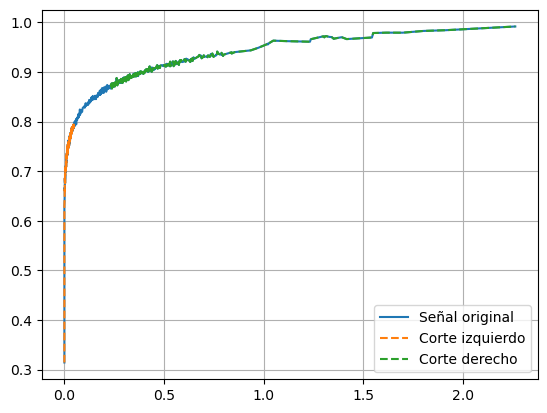

In [14]:
i_inicial = 0
raw_seq_1 = raw_seq[i_inicial:i_inicial+len_left_chain]
t_1 = t[i_inicial:i_inicial+len_left_chain]

print(f'Tamaños de la secuencia izquierda: {len(raw_seq_1)},{len_left_chain}')

raw_seq_2 = raw_seq[i_inicial+len_left_chain+window_size:i_inicial+len_left_chain+window_size + len_right_chain]
t_2 = t[i_inicial+len_left_chain+window_size:i_inicial+len_left_chain+window_size + len_right_chain]

raw_seq_2_bw = raw_seq_2[::-1]
t_2_bw = t_2[::-1]

print(f'Tamaños de la secuencia derecha: {len(raw_seq_2)},{len_right_chain}')

t_window = t[i_inicial+len_left_chain:i_inicial+len_left_chain+window_size]
raw_seq_window = raw_seq[i_inicial+len_left_chain:i_inicial+len_left_chain+window_size]
print(f'Tamaños de la ventana: {len(raw_seq_window)},{window_size}')

plt.plot(t,raw_seq, label='Señal original')
plt.plot(t_1,raw_seq_1, '--', label='Corte izquierdo')
plt.plot(t_2,raw_seq_2, '--', label='Corte derecho')
plt.grid()
plt.legend()
plt.show()

In [15]:
print('t_1 limits:',t_1[0],t_1[-1])
print('t_window limits:', t_window[0],t_window[-1])
print('t_2 limits:',t_2[0],t_2[-1])
print('t limits:',t[0],t[-1])
print('len of times:', len(t_1),len(t_window),len(t_2),len(t))

t_1 limits: 0.00122 0.04985
t_window limits: 0.04989 0.2352
t_2 limits: 0.23556 2.26137
t limits: 0.00122 2.26137
len of times: 600 400 657 1657


In [16]:
predicciones_adelante_1,valores_reales_1 = make_predictions(raw_seq_1, look_back, n_features, raw_seq_window)
diferencia_1 = np.abs(predicciones_adelante_1-raw_seq_window)

predicciones_adelante_2_bw,valores_reales_2_bw = make_predictions(raw_seq_2_bw, look_back, n_features, raw_seq_window[::-1])
predicciones_adelante_2 = predicciones_adelante_2_bw[::-1]
valores_reales_2 = valores_reales_2_bw[::-1]

diferencia_2 = np.abs(predicciones_adelante_2-raw_seq_window)

2024-12-05 00:59:13.705168: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1/1 [==============================] - 0s 26ms/step


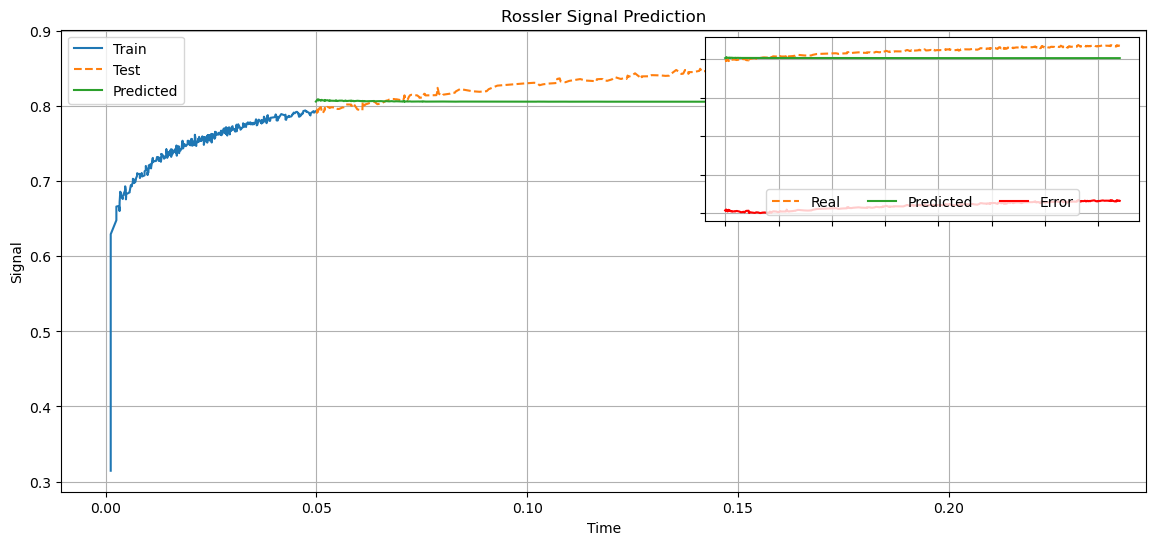

In [17]:
fig, ax = plt.subplots(figsize = (14,6))
ax.plot(t_1,raw_seq_1,label='Train')
ax.plot(t_window,raw_seq_window,'--',label='Test')
ax.plot(t_window,predicciones_adelante_1,label='Predicted')
ax.grid()
ax.set_xlabel('Time')
ax.set_ylabel('Signal')
ax.set_title('Rossler Signal Prediction')
ax.legend(loc = 'upper left')

axin = inset_axes(ax, width = "40%", height = "40%", loc = 'upper right')

axin.plot(t_window,raw_seq_window, '--',label = 'Real', color = 'C1')
axin.plot(t_window,predicciones_adelante_1, label = 'Predicted', color = 'C2')
axin.plot(t_window,diferencia_1, label = 'Error', color = 'red')
axin.set_xticklabels([])
axin.set_yticklabels([])
axin.grid(True)
axin.legend(ncol = 3, loc = 'lower center')


plt.show()

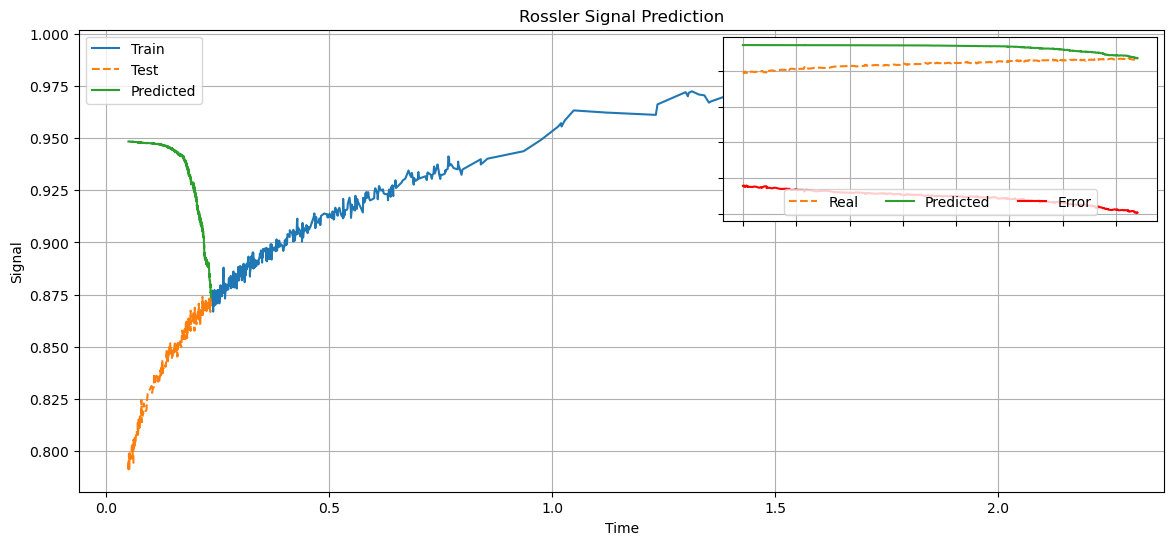

In [18]:
fig, ax = plt.subplots(figsize = (14,6))
ax.plot(t_2,raw_seq_2,label='Train')
ax.plot(t_window,raw_seq_window,'--',label='Test')
ax.plot(t_window,predicciones_adelante_2,label='Predicted')
ax.grid()
ax.set_xlabel('Time')
ax.set_ylabel('Signal')
ax.set_title('Rossler Signal Prediction')
ax.legend(loc = 'upper left')

axin = inset_axes(ax, width = "40%", height = "40%", loc = 'upper right')

axin.plot(t_window,raw_seq_window, '--',label = 'Real', color = 'C1')
axin.plot(t_window,predicciones_adelante_2, label = 'Predicted', color = 'C2')
axin.plot(t_window,diferencia_2, label = 'Error', color = 'red')
axin.set_xticklabels([])
axin.set_yticklabels([])
axin.grid(True)
axin.legend(ncol = 3, loc = 'lower center')


plt.show()


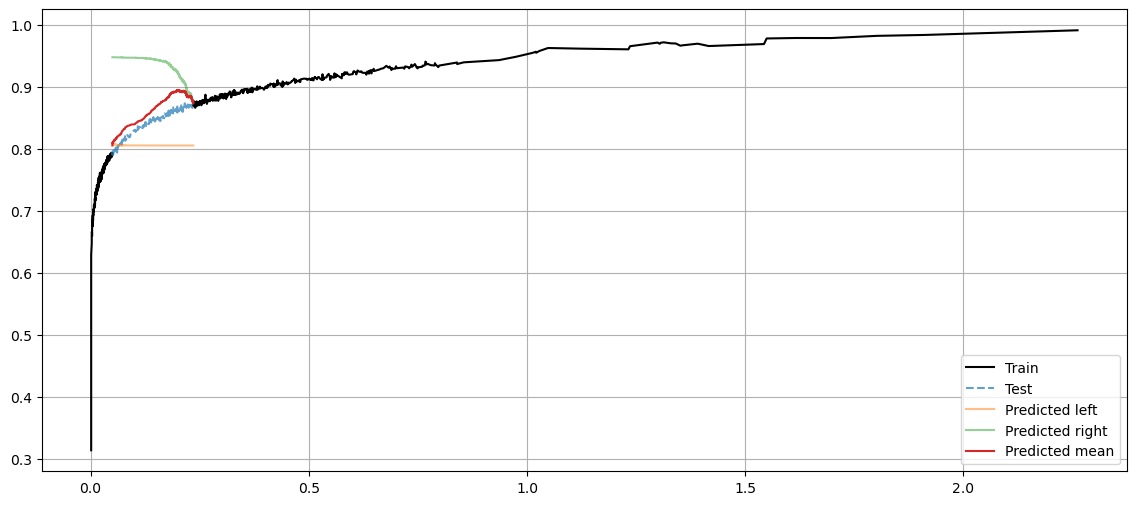

In [19]:
prediction_mean = weighted_mean(predicciones_adelante_1, predicciones_adelante_2)


fig, ax = plt.subplots(figsize = (14,6))
ax.plot(t_1,raw_seq_1,'k',label='Train')
ax.plot(t_window,valores_reales_1,'--',label='Test', alpha = 0.7)
ax.plot(t_window,predicciones_adelante_1,label='Predicted left', alpha = 0.5)
ax.plot(t_2,raw_seq_2,'k')
ax.plot(t_window,predicciones_adelante_2,label='Predicted right', alpha = .5)
ax.plot(t_window,prediction_mean,label='Predicted mean')
ax.grid()
ax.legend()
plt.show()

# Jugando un poco más
Hasta ahora, sólo trabajamos con un modelo de la siguiente pinta:
```
model = Sequential()
model.add(SimpleRNN(20, activation='tanh', input_shape=(look_back, n_features)))
model.add(Dense(1,activation='linear'))
model.compile(optimizer='adam', loss='mse')
```

Ahora bien, teniendo en cuenta que en este caso tenemos dos dinámicas temporales (una asociada a la periodicidad semanal y otra a la del avance de la enfermedad), podríamos tratar de utilizar una capa LSTM en cambio de la RNN para poder captar esta variación.

In [20]:
model = Sequential()
model.add(LSTM(32, activation='tanh',input_shape=(look_back, n_features)))
model.add(Dense(1, activation = 'relu'))
model.compile(optimizer='adam', loss='mse')


predicciones_adelante_1,valores_reales_1 = make_predictions(raw_seq_1, look_back, n_features, raw_seq_window, model = model)
diferencia_1 = np.abs(predicciones_adelante_1-raw_seq_window)

predicciones_adelante_2_bw,valores_reales_2_bw = make_predictions(raw_seq_2_bw, look_back, n_features, raw_seq_window[::-1], model = model)
predicciones_adelante_2 = predicciones_adelante_2_bw[::-1]
valores_reales_2 = valores_reales_2_bw[::-1]

diferencia_2 = np.abs(predicciones_adelante_2-raw_seq_window)

prediction_mean = weighted_mean(predicciones_adelante_1, predicciones_adelante_2)

INFO:tensorflow:Assets written to: ram://deb56293-2d47-4f45-9266-d6db59362e4b/assets


INFO:tensorflow:Assets written to: ram://deb56293-2d47-4f45-9266-d6db59362e4b/assets


1/1 [==============================] - 0s 28ms/step


INFO:tensorflow:Assets written to: ram://d1621402-02c8-48cc-84c6-4b2fe5788480/assets


INFO:tensorflow:Assets written to: ram://d1621402-02c8-48cc-84c6-4b2fe5788480/assets


1/1 [==============================] - 0s 27ms/step


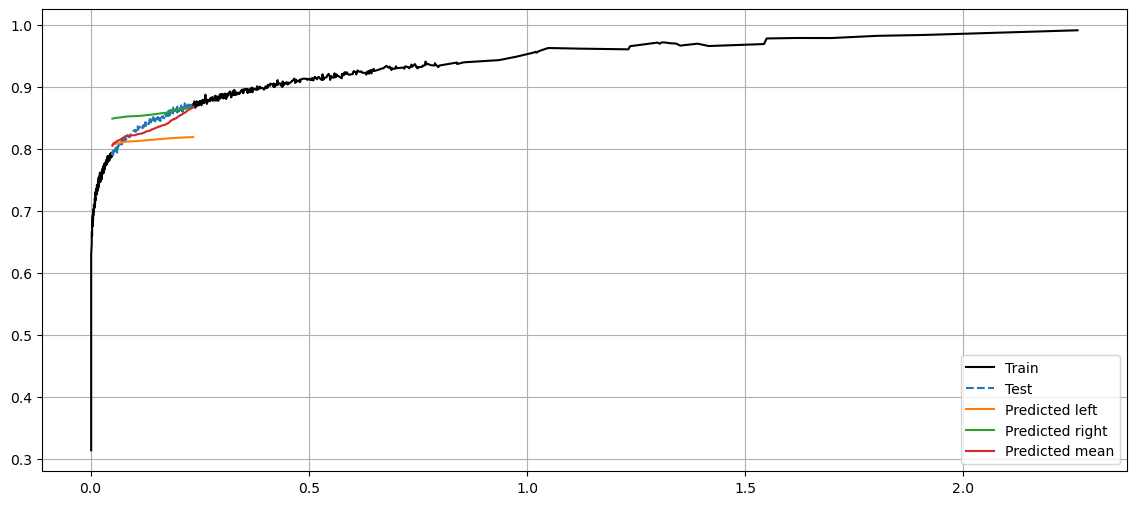

In [21]:
fig, ax = plt.subplots(figsize = (14,6))
ax.plot(t_1,raw_seq_1,'k',label='Train')
ax.plot(t_window,valores_reales_1,'--',label='Test')
ax.plot(t_window,predicciones_adelante_1,label='Predicted left')
ax.plot(t_2,raw_seq_2,'k')
ax.plot(t_window,predicciones_adelante_2,label='Predicted right')
ax.plot(t_window,prediction_mean,label='Predicted mean')
ax.grid()
ax.legend()
plt.show()

# Análisis sistemático
En vez de ir probando, sistematicemos un poco la comparación para distintos sets de parámetros y valores de las ventanas y datos.

In [22]:
look_back = 14
n_features = 1
window_size = 200
len_left_chain = 600
len_right_chain = len(raw_seq) - len_left_chain - window_size
i_inicial = 0
iterations = 10


# longitud de la cadena derecha

raw_seq_1 = raw_seq[i_inicial:i_inicial+len_left_chain]
t_1 = t[i_inicial:i_inicial+len_left_chain]
raw_seq_2 = raw_seq[i_inicial+len_left_chain+window_size:i_inicial+len_left_chain+window_size + len_right_chain]
t_2 = t[i_inicial+len_left_chain+window_size:i_inicial+len_left_chain+window_size + len_right_chain]
raw_seq_2_bw = raw_seq_2[::-1]
t_2_bw = t_2[::-1]
t_window = t[i_inicial+len_left_chain:i_inicial+len_left_chain+window_size]
raw_seq_window = raw_seq[i_inicial+len_left_chain:i_inicial+len_left_chain+window_size]


mod = 'RNN'

prediction_mean_weighted = np.zeros((window_size, iterations))

for i in range(iterations):
    predicciones_adelante_1, _ = make_predictions(raw_seq_1, look_back, n_features, raw_seq_window,)
    #diferencia_1 = np.abs(predicciones_adelante_1-raw_seq_window)

    # split into samples
    predicciones_adelante_2_bw, _ = make_predictions(raw_seq_2_bw, look_back, n_features, raw_seq_window[::-1], )
    predicciones_adelante_2 = predicciones_adelante_2_bw[::-1]
    #valores_reales_2 = valores_reales_2_bw[::-1]

    # Calculamos el error
    #diferencia_2 = np.abs(predicciones_adelante_2-raw_seq_window)
    prediction_mean_weighted[:,i] = weighted_mean(predicciones_adelante_1, predicciones_adelante_2)
np.save(f'saved_iterations/prediction_mean_weightedCOSMO_PPS_{mod}.npy', prediction_mean_weighted)



iterations = 10
mod = 'LSTM'
model = Sequential()
model.add(LSTM(32, activation='tanh',input_shape=(look_back, n_features)))
model.add(Dense(1, activation = 'relu'))
model.compile(optimizer='adam', loss='mse')

prediction_mean_weighted = np.zeros((window_size, iterations))

for i in range(iterations):
    predicciones_adelante_1, _ = make_predictions(raw_seq_1, look_back, n_features, raw_seq_window, model = model)
    #diferencia_1 = np.abs(predicciones_adelante_1-raw_seq_window)

    # split into samples
    predicciones_adelante_2_bw, _ = make_predictions(raw_seq_2_bw, look_back, n_features, raw_seq_window[::-1], model = model)
    predicciones_adelante_2 = predicciones_adelante_2_bw[::-1]
    #valores_reales_2 = valores_reales_2_bw[::-1]

    # Calculamos el error
    #diferencia_2 = np.abs(predicciones_adelante_2-raw_seq_window)
    prediction_mean_weighted[:,i] = weighted_mean(predicciones_adelante_1, predicciones_adelante_2)
np.save(f'saved_iterations/prediction_mean_weightedCOSMO_PPS_{mod}.npy', prediction_mean_weighted)

mod = 'BidirectionalLSTM'
model = Sequential()
model.add(Bidirectional(LSTM(32, activation='tanh',input_shape=(look_back, n_features))))
model.add(Dense(1, activation = 'relu'))
model.compile(optimizer='adam', loss='mse')

prediction_mean_weighted = np.zeros((window_size, iterations))

for i in range(iterations):
    predicciones_adelante_1, _ = make_predictions(raw_seq_1, look_back, n_features, raw_seq_window, model = model)
    #diferencia_1 = np.abs(predicciones_adelante_1-raw_seq_window)

    # split into samples
    predicciones_adelante_2_bw, _ = make_predictions(raw_seq_2_bw, look_back, n_features, raw_seq_window[::-1], model = model)
    predicciones_adelante_2 = predicciones_adelante_2_bw[::-1]
    #valores_reales_2 = valores_reales_2_bw[::-1]

    # Calculamos el error
    #diferencia_2 = np.abs(predicciones_adelante_2-raw_seq_window)
    prediction_mean_weighted[:,i] = weighted_mean(predicciones_adelante_1, predicciones_adelante_2)
np.save(f'saved_iterations/prediction_mean_weightedCOSMO_PPS_{mod}.npy', prediction_mean_weighted)

mod = 'BidirectionalStackedLSTM'
model = Sequential()
model.add(Bidirectional(LSTM(32, activation='tanh',input_shape=(look_back, n_features), return_sequences=True)))
model.add(Bidirectional(LSTM(64, activation='tanh',input_shape=(look_back, n_features))))
model.add(Dense(1, activation = 'relu'))
model.compile(optimizer='adam', loss='mse')

prediction_mean_weighted = np.zeros((window_size, iterations))

for i in range(iterations):
    predicciones_adelante_1, _ = make_predictions(raw_seq_1, look_back, n_features, raw_seq_window, model = model)
    #diferencia_1 = np.abs(predicciones_adelante_1-raw_seq_window)

    # split into samples
    predicciones_adelante_2_bw, _ = make_predictions(raw_seq_2_bw, look_back, n_features, raw_seq_window[::-1], model = model)
    predicciones_adelante_2 = predicciones_adelante_2_bw[::-1]
    #valores_reales_2 = valores_reales_2_bw[::-1]

    # Calculamos el error
    #diferencia_2 = np.abs(predicciones_adelante_2-raw_seq_window)
    prediction_mean_weighted[:,i] = weighted_mean(predicciones_adelante_1, predicciones_adelante_2)
np.save(f'saved_iterations/prediction_mean_weightedCOSMO_PPS_{mod}.npy', prediction_mean_weighted)

1/1 [==============================] - 0s 30ms/step


INFO:tensorflow:Assets written to: ram://e59900e0-ea4a-4ab7-b8c2-5e4b9951d710/assets


INFO:tensorflow:Assets written to: ram://e59900e0-ea4a-4ab7-b8c2-5e4b9951d710/assets


1/1 [==============================] - 0s 22ms/step


INFO:tensorflow:Assets written to: ram://13cbda19-7413-4ec0-8f32-4f288673fe38/assets


INFO:tensorflow:Assets written to: ram://13cbda19-7413-4ec0-8f32-4f288673fe38/assets


1/1 [==============================] - 0s 21ms/step


INFO:tensorflow:Assets written to: ram://ceb6f86e-f080-4265-9904-b95c95430f75/assets


INFO:tensorflow:Assets written to: ram://ceb6f86e-f080-4265-9904-b95c95430f75/assets


1/1 [==============================] - 0s 21ms/step


INFO:tensorflow:Assets written to: ram://cb654ca9-73d3-4aa2-9426-fb94d6d5cecb/assets


INFO:tensorflow:Assets written to: ram://cb654ca9-73d3-4aa2-9426-fb94d6d5cecb/assets


1/1 [==============================] - 0s 57ms/step


INFO:tensorflow:Assets written to: ram://8fa51b2b-d323-4007-9772-2d80f96818dc/assets


INFO:tensorflow:Assets written to: ram://8fa51b2b-d323-4007-9772-2d80f96818dc/assets


1/1 [==============================] - 0s 22ms/step


INFO:tensorflow:Assets written to: ram://3a4ee3c9-4236-41aa-a913-a5f22fb55069/assets


INFO:tensorflow:Assets written to: ram://3a4ee3c9-4236-41aa-a913-a5f22fb55069/assets


1/1 [==============================] - 0s 24ms/step


INFO:tensorflow:Assets written to: ram://5b50ac37-6920-4171-8c83-076de020461f/assets


INFO:tensorflow:Assets written to: ram://5b50ac37-6920-4171-8c83-076de020461f/assets


1/1 [==============================] - 0s 27ms/step


INFO:tensorflow:Assets written to: ram://a1098aa2-c992-4578-8e6e-0f15b2d1ae07/assets


INFO:tensorflow:Assets written to: ram://a1098aa2-c992-4578-8e6e-0f15b2d1ae07/assets


1/1 [==============================] - 0s 25ms/step


INFO:tensorflow:Assets written to: ram://6d392328-d355-4ad3-8cc2-3bf9b8a7b750/assets


INFO:tensorflow:Assets written to: ram://6d392328-d355-4ad3-8cc2-3bf9b8a7b750/assets


1/1 [==============================] - 0s 15ms/step


INFO:tensorflow:Assets written to: ram://44605d68-acbe-4f2e-87de-8a371d792e76/assets


INFO:tensorflow:Assets written to: ram://44605d68-acbe-4f2e-87de-8a371d792e76/assets


1/1 [==============================] - 0s 15ms/step


INFO:tensorflow:Assets written to: ram://04f7e1cc-f102-4441-a806-8004c83ff861/assets


INFO:tensorflow:Assets written to: ram://04f7e1cc-f102-4441-a806-8004c83ff861/assets


1/1 [==============================] - 0s 15ms/step


INFO:tensorflow:Assets written to: ram://a67d476c-b451-4b04-afe7-c829ef8b09ff/assets


INFO:tensorflow:Assets written to: ram://a67d476c-b451-4b04-afe7-c829ef8b09ff/assets


1/1 [==============================] - 0s 14ms/step


INFO:tensorflow:Assets written to: ram://b5613d5d-997b-4562-852c-45d75664b806/assets


INFO:tensorflow:Assets written to: ram://b5613d5d-997b-4562-852c-45d75664b806/assets


1/1 [==============================] - 0s 16ms/step


INFO:tensorflow:Assets written to: ram://9d990b1d-6b5c-45f4-b852-230f18be9425/assets


INFO:tensorflow:Assets written to: ram://9d990b1d-6b5c-45f4-b852-230f18be9425/assets


1/1 [==============================] - 0s 14ms/step


INFO:tensorflow:Assets written to: ram://2e5f72d7-c469-4faf-b9ff-0cebbf1183b9/assets


INFO:tensorflow:Assets written to: ram://2e5f72d7-c469-4faf-b9ff-0cebbf1183b9/assets


1/1 [==============================] - 0s 14ms/step


INFO:tensorflow:Assets written to: ram://780c487e-858a-4de8-bcc0-a05c33eed43d/assets


INFO:tensorflow:Assets written to: ram://780c487e-858a-4de8-bcc0-a05c33eed43d/assets


1/1 [==============================] - 0s 14ms/step


INFO:tensorflow:Assets written to: ram://86598ff4-8033-418f-95ba-bbf87f03be8d/assets


INFO:tensorflow:Assets written to: ram://86598ff4-8033-418f-95ba-bbf87f03be8d/assets


1/1 [==============================] - 0s 14ms/step


INFO:tensorflow:Assets written to: ram://70b4c9f4-6870-4148-97cc-ed1967004d22/assets


INFO:tensorflow:Assets written to: ram://70b4c9f4-6870-4148-97cc-ed1967004d22/assets


1/1 [==============================] - 0s 16ms/step


INFO:tensorflow:Assets written to: ram://b8abd7cf-541a-4c85-8893-e48c1e7b9760/assets


INFO:tensorflow:Assets written to: ram://b8abd7cf-541a-4c85-8893-e48c1e7b9760/assets


1/1 [==============================] - 0s 15ms/step


INFO:tensorflow:Assets written to: ram://4aae04bc-89dc-4e40-a64a-843b9f4cfdd6/assets


INFO:tensorflow:Assets written to: ram://4aae04bc-89dc-4e40-a64a-843b9f4cfdd6/assets


1/1 [==============================] - 0s 39ms/step


Text(0.5, 0.98, '$1-\\sigma$ Error Plot of Signal Predictions')

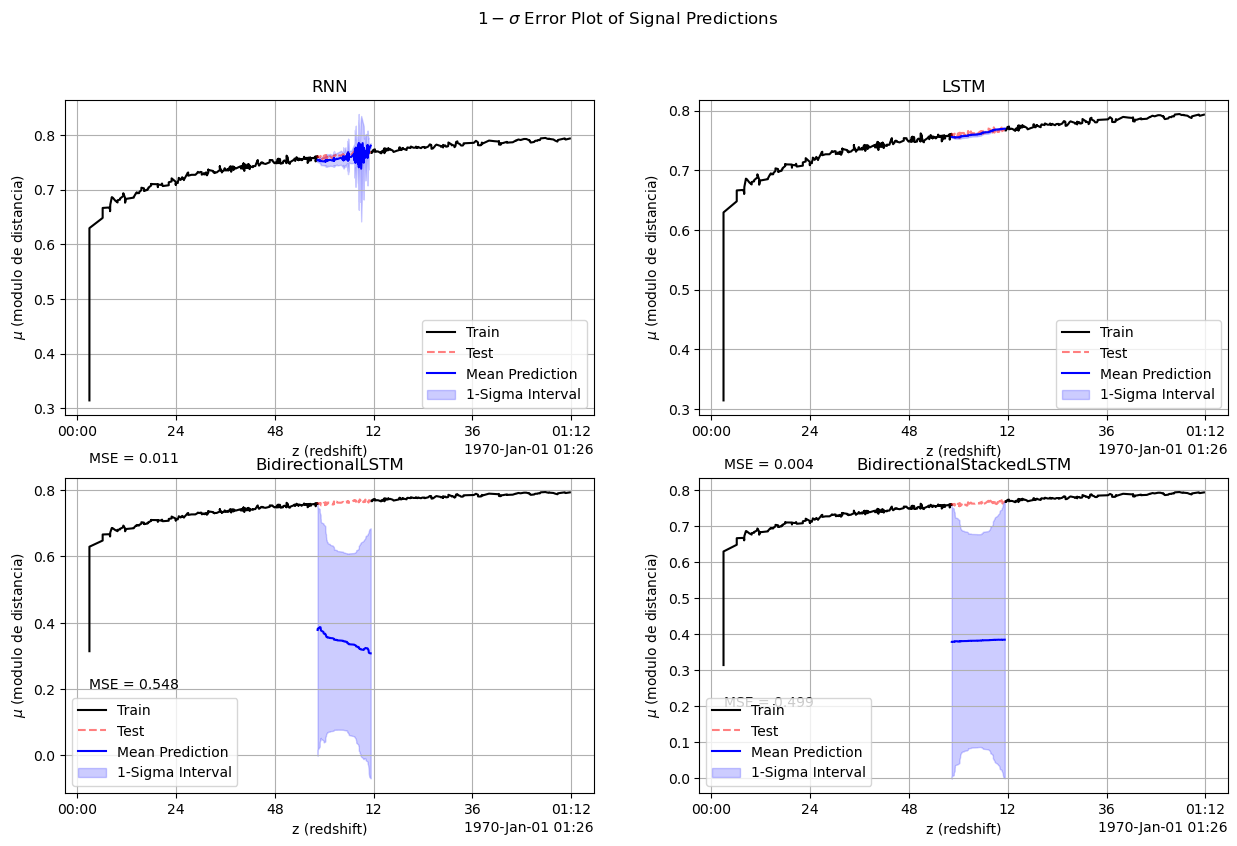

In [23]:
import matplotlib.dates as mdates
mods = ['RNN', 'LSTM', 'BidirectionalLSTM', 'BidirectionalStackedLSTM']

fig, axs = plt.subplots(2,2, figsize = (15, 9))

for m, ax in zip(mods, fig.get_axes()):
    
    output = np.load(f'saved_iterations/prediction_mean_weightedCOSMO_PPS_{m}.npy')
    num_steps = output.shape[0]
    dt = 1
    t = np.linspace(0, num_steps * dt, num_steps)

    # Calculate the mean and standard deviation of the predictions
    mean_prediction = np.mean(output, axis=1)
    std_prediction = np.std(output, axis=1)


    ax.plot(t_1, raw_seq_1, 'k', label='Train')
    ax.plot(t_2, raw_seq_2, 'k')
    ax.plot(t_window, raw_seq_window, '--r', label='Test', alpha=0.5)

    # Plot the mean prediction
    ax.plot(t_window, mean_prediction, 'b', label='Mean Prediction')

    # Plot the 1-sigma confidence interval
    ax.fill_between(t_window, mean_prediction - std_prediction, mean_prediction + std_prediction, color='blue', alpha=0.2, label='1-Sigma Interval')

    # Add grid, legend, and labels
    ax.grid()
    ax.legend()
    ax.set_xlabel('z (redshift)')
    ax.set_ylabel(r'$\mu$ (modulo de distancia)')
    ax.set_title(f'{m}')
    mse = MSE(raw_seq_window, output)
    ax.text(t_1[0], 0.2, f'MSE = {round(mse,3)}')

    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))


    

fig.suptitle(r'$1-\sigma$ Error Plot of Signal Predictions')
